# Taxi trips

The yellow and green taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). The trip data was not created by the TLC, and TLC makes no representations as to the accuracy of these data.

Data can be found [here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
from scipy import stats

path = 'C:/Users/Zaca/Documents/Datasets/taxis/yellow_tripdata_2017-06.csv'

In [86]:
# open data and explore
taxi = pd.read_csv(path)

In [87]:
# looking at the size of the data
taxi.shape

(9656993, 17)

A dictionary to each column description can be found [here](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf).

In [88]:
# examine the data
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2017-06-08 07:52:31,2017-06-08 08:01:32,6,1.03,1,N,161,140,1,7.5,1.0,0.5,1.86,0.0,0.3,11.16
1,2,2017-06-08 08:08:18,2017-06-08 08:14:00,6,1.03,1,N,162,233,1,6.0,1.0,0.5,2.34,0.0,0.3,10.14
2,2,2017-06-08 08:16:49,2017-06-08 15:43:22,6,5.63,1,N,137,41,2,21.5,1.0,0.5,0.00,0.0,0.3,23.30
3,2,2017-06-29 15:52:35,2017-06-29 16:03:27,6,1.43,1,N,142,48,1,8.5,1.0,0.5,0.88,0.0,0.3,11.18
4,1,2017-06-01 00:00:00,2017-06-01 00:03:43,1,0.60,1,N,140,141,1,4.5,0.5,0.5,2.00,0.0,0.3,7.80


In [89]:
# examine dtypes
taxi.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
RatecodeID                 int64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [90]:
# checking for nans
taxi.isna().sum()
# beautiful

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
dtype: int64

# Exploring and understanding column content

**VendorID**: code indicating the TPEP provider that provided the record. 
- The TLC (Taxi-Limousine Comission) requires all medallion taxicabs to be equipped with a Taxicab Technology System (“T-PEP”), which processes credit, debit, and prepaid card payments, enables taxicab drivers to receive text messages from the TLC, allows the TLC to collect electronic trip sheet data, and possesses a Passenger Information Monitor (“PIM”), which displays content to taxicab passengers.

In [91]:
# vendorID
taxi.VendorID.value_counts()
# I don't I'll be very interested in this column for my analysis.


2    5281999
1    4374994
Name: VendorID, dtype: int64

**passenger_count**: the number of passengers in the vehicle. This is a driver-entered value.

In [92]:
taxi.passenger_count.value_counts()

# there are some trips with zero passengers. because this is a driver input value,
# I think zeros are probably mistakes. In any case they are only 595 in 10M, so we can remove them later.

1    6933189
2    1385066
5     455753
3     406162
6     288220
4     187979
0        548
8         30
7         26
9         20
Name: passenger_count, dtype: int64

**trip_distance**: the elapsed trip distance in miles reported by the taximeter.

count    9.656993e+06
mean     2.978617e+00
std      5.704095e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.670000e+00
75%      3.100000e+00
max      9.496980e+03
Name: trip_distance, dtype: float64


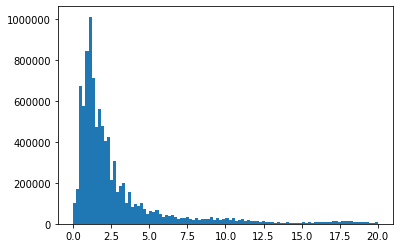

In [93]:
print(taxi.trip_distance.describe())
# the seems to be a 600 mile trip as maximum. This doesn't feel like your normal taxi trip in NYC.
# we might be interested in removing these outliers.

plt.hist(taxi.trip_distance, bins=100, range=(0, 20));

**RatecodeID**: the final rate code in effect at the end of the trip.
1. Standard rate
2. JFK
3. Newark
4. Nassau or Westchester
5. Negotiated fare
6. Group ride


In [94]:
# ratecodeID
taxi.RatecodeID.value_counts()
# the number 99 is probably some error in the system
# nonetheless, I think I might only be interested in keeping the normal fare, it's most of the data anyway.

1     9374033
2      221857
5       33852
3       21490
4        5439
99        231
6          91
Name: RatecodeID, dtype: int64

**Store_and_fwd_flag**: this flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.

In [95]:
# store and forward
taxi.store_and_fwd_flag.value_counts()

# doesn't seem to have much interest.

N    9624906
Y      32087
Name: store_and_fwd_flag, dtype: int64

**PULocationID**: TLC Taxi Zone in which the taximeter was engaged.

In [96]:
# pick-up-location code has 261 unique values
taxi.PULocationID.value_counts()

# this is a pretty important variable, i'm probably gonna have to think of a way of dealing with those later.

237    379701
161    358983
236    343355
162    331577
186    328511
        ...  
27          2
104         1
109         1
176         1
245         1
Name: PULocationID, Length: 260, dtype: int64

**DOLocationID**: TLC Taxi Zone in which the taximeter was disengaged.

In [97]:
# drop-off location has 262 unique values.
taxi.DOLocationID.value_counts()

161    364226
236    350744
237    332690
170    310935
230    298762
        ...  
44         27
2          10
105         8
99          2
110         1
Name: DOLocationID, Length: 262, dtype: int64

**payment_type**: a numeric code signifying how the passenger paid for the trip.
1. Credit card
2. Cash
3. No charge
4. Dispute
5. Unknown
6. Voided trip

In [98]:
taxi.payment_type.value_counts()
# In the payment type we can observe one of the main problems with the data.
# Tips are only included for credit card payments.
# We might have to only include these rides in our tip recommendation system.

1    6514906
2    3073865
3      52711
4      15510
5          1
Name: payment_type, dtype: int64

**fare_amount**: the time-and-distance fare calculated by the meter.

count    9.656993e+06
mean     1.328727e+01
std      2.151675e+02
min     -5.500000e+02
25%      6.500000e+00
50%      9.500000e+00
75%      1.500000e+01
max      6.304618e+05
Name: fare_amount, dtype: float64


2     0.988533
1     0.009945
5     0.001174
4     0.000170
3     0.000156
99    0.000022
Name: RatecodeID, dtype: float64

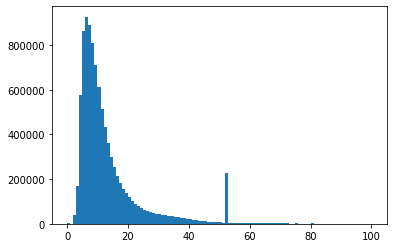

In [99]:
print(taxi.fare_amount.describe())

# it seems like there was a trip worth 175k, that doesn't sound right at all.

plt.hist(taxi.fare_amount, bins=100, range=(0, 100));

# there's a couple of weird things here:
# there are some negative values. if we assume this is an error we can solve it by taking the absolute.
# there's always a weird peak at 52$. 

# taxi.fare_amount.value_counts() here I should detect the peak using the mode between 40-60 or something like that.

taxi[taxi.fare_amount == 52]['RatecodeID'].value_counts(normalize=True)

# it seems that a lot of this errors come from zone 132.
# ok I figured it out, it seems to be something static about the fare from JFK Airport.
# this is solves if we only include trips with ratecode 1

**extra**: Miscellaneous extras and surcharges. Currently, this only includes the .5 and 1 dollar rush hour and overnight charges.

In [100]:
taxi.extra.value_counts()

 0.00     4958655
 0.50     3086020
 1.00     1568003
 4.50       41475
-0.50        1582
-1.00         679
 0.30         224
 1.30         102
-4.50          79
 0.80          72
 0.02          19
 0.10          16
 0.20          13
 1.50          12
 4.80           6
 22.50          6
 4.54           5
 0.40           3
-0.45           2
 2.00           2
 0.90           2
 0.01           2
 0.60           2
 2.50           1
 0.21           1
-31.61          1
-0.20           1
 0.70           1
 1.01           1
-50.56          1
-0.49           1
-0.35           1
 0.49           1
 7.06           1
 7.40           1
Name: extra, dtype: int64

**improvement_surcharge**: 0.30 dollar improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015.

In [101]:
# this charge seems to be present in all of the trips so it doesn't have much information.
taxi.improvement_surcharge.value_counts()

 0.3    9648899
-0.3       4708
 0.0       3364
 1.0         22
Name: improvement_surcharge, dtype: int64

In [102]:
# this column is the same as the improvement surcharge.
taxi.mta_tax.value_counts()

 0.50      9605702
 0.00        45982
-0.50         4576
 0.85          655
 0.25           56
 3.00            6
 0.32            2
 140.00          1
 32.41           1
 24.00           1
 31.00           1
 43.00           1
 97.75           1
 51.36           1
 11.30           1
 10.30           1
 0.90            1
 53.80           1
 31.55           1
 14.65           1
 1.30            1
Name: mta_tax, dtype: int64

**tip_amount**: This field is automatically populated for credit card tips. Cash tips are not included.

In [103]:
# the target variable for our purposes
taxi.tip_amount.describe()
#plt.hist(taxi.tip_amount, bins=100);

count    9.656993e+06
mean     1.878480e+00
std      2.696221e+00
min     -7.400000e+01
25%      0.000000e+00
50%      1.360000e+00
75%      2.460000e+00
max      4.440000e+02
Name: tip_amount, dtype: float64

**toll_amount**: Total amount of all tolls paid in trip. 

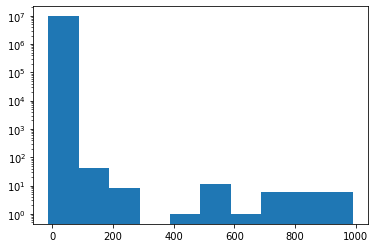

In [104]:
taxi.tolls_amount.value_counts()
plt.hist(taxi.tolls_amount, log=True);

In [105]:
# transforming to datetime
taxi['tpep_pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
taxi['tpep_dropoff_datetime'] = pd.to_datetime(taxi['tpep_dropoff_datetime'])

In [106]:
taxi['duration'] = taxi['tpep_dropoff_datetime'] - taxi['tpep_pickup_datetime']
taxi['duration'] = taxi['duration'].dt.seconds/60
taxi['weekday'] = [x.weekday() for x in taxi['tpep_pickup_datetime']]
taxi['hour'] = taxi['tpep_pickup_datetime'].dt.hour

# Data cleaning

In [107]:
taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'duration', 'weekday', 'hour'],
      dtype='object')

In [108]:
# droping columns
drop_cols = ['VendorID', 'store_and_fwd_flag', 'mta_tax', 'improvement_surcharge', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']
taxi.drop(labels=drop_cols, axis=1, inplace=True)

In [109]:
# removing 0 passengers
taxi = taxi[(taxi.passenger_count != 0) & (taxi.RatecodeID == 1) & (taxi.payment_type == 1)]

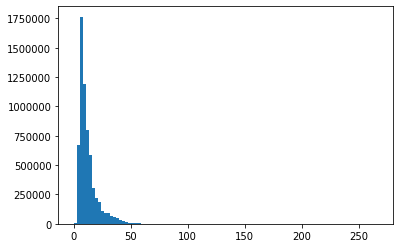

In [110]:
plt.hist(taxi.fare_amount, bins=100);

In [111]:
z = np.abs(stats.zscore(taxi))

C:\Users\Zaca\Anaconda3\lib\site-packages\scipy\stats\stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [112]:
taxi_o = taxi[(z < 3).all(axis=1)]

C:\Users\Zaca\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [114]:
z

array([[3.482209  , 0.59106317,        nan, ..., 0.13910571, 0.02053249,
        1.04355056],
       [3.482209  , 0.59106317,        nan, ..., 0.20376272, 0.02053249,
        0.88734194],
       [3.482209  , 0.45065351,        nan, ..., 0.10304075, 0.02053249,
        0.20611837],
       ...,
       [0.48404603, 0.63669631,        nan, ..., 0.03188555, 0.02053249,
        0.36232699],
       [0.30920497, 4.1793551 ,        nan, ..., 1.15858314, 0.02053249,
        0.36232699],
       [0.48404603, 0.34885651,        nan, ..., 0.05064148, 0.02053249,
        0.36232699]])